# CNN for Lung cancer classification

## Importing the libraries

In [ ]:
import keras
import keras.backend as K
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from time import time
import numpy as np

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, MaxPool2D, AvgPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D, AvgPool2D
tf.__version__

## Loading the images

In [ ]:
from google.colab import drive
import zipfile
drive.mount('/content/drive')

path = '/content/Preprosed Image.zip'

zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

In [ ]:
# Original Image plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1)
image1 = cv2.imread('/content/Data/test/adenocarcinoma/adenocarcinoma000113 (7).png')
image2 = cv2.imread('/content/Data/test/large.cell.carcinoma/large.cell.carcinoma000115 (2).png')
image3 = cv2.imread('/content/Data/test/normal/normal10 - Copy (3).png')
image4 = cv2.imread('/content/Data/test/squamous.cell.carcinoma/squamous.cell.carcinoma000115 (4).png')
plt.imshow(image1, cmap="gray")
plt.title("adenocarcinoma")
plt.subplot(1, 4, 2)
plt.imshow(image2, cmap="gray")
plt.title("large.cell.carcinoma")
plt.subplot(1, 4, 3)
plt.imshow(image3, cmap="gray")
plt.title("normal")
plt.subplot(1, 4, 4)
plt.imshow(image4, cmap="gray")
plt.title("squamous.cell.carcinoma")
plt.show()

In [ ]:
# Prreprossed Image plotting
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 20))
plt.subplot(1, 4, 1)
image1 = cv2.imread('/content/Preprosed Image/test/adenocarcinoma/adenocarcinoma000113 (7).png')
image2 = cv2.imread('/content/Preprosed Image/test/large.cell.carcinoma/large.cell.carcinoma000115 (2).png')
image3 = cv2.imread('/content/Preprosed Image/test/normal/normal10 - Copy (3).png')
image4 = cv2.imread('/content/Preprosed Image/test/squamous.cell.carcinoma/squamous.cell.carcinoma000115 (4).png')
plt.imshow(image1, cmap="gray")
plt.title("adenocarcinoma")
plt.subplot(1, 4, 2)
plt.imshow(image2, cmap="gray")
plt.title("large.cell.carcinoma")
plt.subplot(1, 4, 3)
plt.imshow(image3, cmap="gray")
plt.title("normal")
plt.subplot(1, 4, 4)
plt.imshow(image4, cmap="gray")
plt.title("squamous.cell.carcinoma")
plt.show()

## Train and test set

In [ ]:
train = '/content/Preprosed Image/train'
valid = '/content/Preprosed Image/valid'
test = '/content/Preprosed Image/test'

# training_generator = ImageDataGenerator(rescale=1./255,
#                                         rotation_range=7,
#                                         horizontal_flip=True,
#                                         zoom_range=0.2)

training_generator = ImageDataGenerator(rescale=1./255)
train_dataset = training_generator.flow_from_directory(train,
                                                        target_size = (299, 299),
                                                        batch_size = 8,
                                                        class_mode = 'categorical',
                                                        shuffle = True)

valid_generator = ImageDataGenerator(rescale=1./255)
valid_dataset = valid_generator.flow_from_directory(valid,
                                                     target_size = (299, 299),
                                                     batch_size = 8,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory(test,
                                                     target_size = (299, 299),
                                                     batch_size = 1,
                                                     class_mode = 'categorical',
                                                     shuffle = False)

Found 598 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 314 images belonging to 4 classes.


In [ ]:
train_dataset.class_indices

## InceptionV3

In [ ]:
from keras.models import Model
from keras.layers import concatenate
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization

def conv_with_Batch_Normalisation(prev_layer , nbr_kernels , filter_Size , strides =(1,1) , padding = 'same'):
    x = Conv2D(filters=nbr_kernels, kernel_size = filter_Size, strides=strides , padding=padding)(prev_layer)
    x = BatchNormalization(axis=3)(x)
    x = Activation(activation='relu')(x)
    return x

def StemBlock(prev_layer):
    x = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 32, filter_Size=(3,3) , strides=(2,2))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 32, filter_Size=(3,3))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 64, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 80, filter_Size=(1,1))
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 192, filter_Size=(3,3))
    x = MaxPool2D(pool_size=(3,3) , strides=(2,2)) (x)
    
    return x    
  
def InceptionBlock_A(prev_layer  , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels=96, filter_Size=(3,3))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=48, filter_Size=(1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels=64, filter_Size=(3,3)) # may be 3*3
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels=64, filter_Size=(1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis=3)
    
    return output

def InceptionBlock_B(prev_layer , nbr_kernels):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = nbr_kernels, filter_Size = (7,1))    
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = nbr_kernels, filter_Size = (1,1))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = nbr_kernels, filter_Size = (1,7))
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 192, filter_Size = (7,1))
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding ='same') (prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output    

def InceptionBlock_C(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 448, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,3))
    branch1_1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (1,3))    
    branch1_2 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 384, filter_Size = (3,1))
    branch1 = concatenate([branch1_1 , branch1_2], axis = 3)
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size = (1,1))
    branch2_1 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (1,3))
    branch2_2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 384, filter_Size = (3,1))
    branch2 = concatenate([branch2_1 , branch2_2], axis = 3)
    
    branch3 = AveragePooling2D(pool_size=(3,3) , strides=(1,1) , padding='same')(prev_layer)
    branch3 = conv_with_Batch_Normalisation(branch3, nbr_kernels = 192, filter_Size = (1,1))
    
    branch4 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 320, filter_Size = (1,1))
    
    output = concatenate([branch1 , branch2 , branch3 , branch4], axis = 3)
    
    return output

def ReductionBlock_A(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 64, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 96, filter_Size = (3,3) , strides=(2,2) ) #, padding='valid'
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 384, filter_Size=(3,3) , strides=(2,2) )
    
    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) , padding='same')(prev_layer)
    
    output = concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output

def ReductionBlock_B(prev_layer):
    
    branch1 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (1,7))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (7,1))
    branch1 = conv_with_Batch_Normalisation(branch1, nbr_kernels = 192, filter_Size = (3,3) , strides=(2,2) , padding = 'valid')
    
    branch2 = conv_with_Batch_Normalisation(prev_layer, nbr_kernels = 192, filter_Size = (1,1) )
    branch2 = conv_with_Batch_Normalisation(branch2, nbr_kernels = 320, filter_Size = (3,3) , strides=(2,2) , padding='valid' )

    branch3 = MaxPool2D(pool_size=(3,3) , strides=(2,2) )(prev_layer)
    
    output = concatenate([branch1 , branch2 , branch3], axis = 3)
    
    return output

def auxiliary_classifier(prev_Layer):
    x = AveragePooling2D(pool_size=(5,5) , strides=(3,3)) (prev_Layer)
    x = conv_with_Batch_Normalisation(x, nbr_kernels = 128, filter_Size = (1,1))
    x = Flatten()(x)
    x = Dense(units = 768, activation='relu') (x)
    x = Dropout(rate = 0.2) (x)
    x = Dense(units = 4, activation='softmax') (x)
    return x

def InceptionV3():
    
    input_layer = Input(shape=(299 , 299 , 3))
    
    x = StemBlock(input_layer)
    
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 32)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    x = InceptionBlock_A(prev_layer = x ,nbr_kernels = 64)
    
    x = ReductionBlock_A(prev_layer = x )
    
    x = InceptionBlock_B(prev_layer = x  , nbr_kernels = 128)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 160)
    x = InceptionBlock_B(prev_layer = x , nbr_kernels = 192)
    
    Aux = auxiliary_classifier(prev_Layer = x)
    
    x = ReductionBlock_B(prev_layer = x)
    
    x = InceptionBlock_C(prev_layer = x)
    x = InceptionBlock_C(prev_layer = x)
    
    x = GlobalAveragePooling2D()(x)
    x = Dense(units=2048, activation='relu') (x)
    x = Dropout(rate = 0.2) (x)
    x = Dense(units=4, activation='softmax') (x)
    
    model = Model(inputs = input_layer , outputs = [x , Aux] , name = 'Inception-V3')
    
    return model

In [ ]:
IncepV3 = InceptionV3()
IncepV3.summary()

Model: "Inception-V3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 299, 299, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 150, 150, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 150, 150, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                      

In [ ]:
# To print the flow diagram 
from tensorflow.keras.utils import plot_model
plot_model(IncepV3, to_file='inception_v3_with_dense_layers_model.png', show_shapes=False, show_layer_names=True)

In [ ]:
# from keras.callbacks import ModelCheckpoint
# weightpath ="./best_model.hdf5"
# checkpoint = ModelCheckpoint(weightpath, monitor='val_dense_3_accuracy', verbose=1, save_best_only=True, save_weights_only=True, mode='max')
# callbacks_list = [checkpoint]
# IncepV3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics = ['accuracy'])
# IncepV3_history = IncepV3.fit_generator(train_dataset, epochs = 50, validation_data = valid_dataset, callbacks=callbacks_list)
# filepath="IncepV3.hdf5"
# IncepV3.save(filepath)

In [ ]:
######################################################### Save every epoch weight to get best test accuray weight
# import os
# checkpoint_path = "./cp-{epoch:d}.hdf5"
# checkpoint_dir = os.path.dirname(checkpoint_path)

# cp_callback = tf.keras.callbacks.ModelCheckpoint(
#    checkpoint_path, verbose=1, save_weights_only=True,
#    save_freq='epoch')


# IncepV3.save_weights(checkpoint_path.format(epoch=0))
# IncepV3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics = ['accuracy'])
# IncepV3_history = IncepV3.fit_generator(train_dataset, epochs = 100, validation_data = valid_dataset, callbacks = [cp_callback])


# from sklearn.metrics import accuracy_score
# for i in range(0, 100):
#   model_json = IncepV3.to_json()
#   with open('network.json','w') as json_file:
#     json_file.write(model_json)
#   with open('network.json', 'r') as json_file:
#     json_saved_model = json_file.read()
#     json_saved_model
#   model_loaded = tf.keras.models.model_from_json(json_saved_model)
#   model_loaded.load_weights(f'cp-{i}.hdf5')
#   model_loaded.compile(loss = 'categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
#   Y_pred = model_loaded.predict(test_dataset)
#   pred_incepV3_0 = np.argmax(Y_pred[0], axis = 1)
#   pred_incepV3_0
#   print(accuracy_score(test_dataset.classes, pred_incepV3_0))

In [ ]:
IncepV3.compile(optimizer='sgd', loss='categorical_crossentropy', metrics = ['accuracy'])
IncepV3_history = IncepV3.fit_generator(train_dataset, epochs = 100, validation_data = valid_dataset)

<ipython-input-11-a962ae7eeef7>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  IncepV3_history = IncepV3.fit_generator(train_dataset, epochs = 100, validation_data = valid_dataset)


Epoch 1/100
75/75 [==============================] - 35s 219ms/step - loss: 2.6292 - dense_3_loss: 1.2678 - dense_1_loss: 1.3615 - dense_3_accuracy: 0.4114 - dense_1_accuracy: 0.4950 - val_loss: 2.9452 - val_dense_3_loss: 1.4664 - val_dense_1_loss: 1.4788 - val_dense_3_accuracy: 0.3194 - val_dense_1_accuracy: 0.3056
Epoch 2/100
75/75 [==============================] - 11s 151ms/step - loss: 1.7162 - dense_3_loss: 0.9925 - dense_1_loss: 0.7237 - dense_3_accuracy: 0.5686 - dense_1_accuracy: 0.6890 - val_loss: 3.5928 - val_dense_3_loss: 1.8207 - val_dense_1_loss: 1.7721 - val_dense_3_accuracy: 0.3333 - val_dense_1_accuracy: 0.3056
Epoch 3/100
75/75 [==============================] - 14s 193ms/step - loss: 1.3768 - dense_3_loss: 0.8402 - dense_1_loss: 0.5365 - dense_3_accuracy: 0.6237 - dense_1_accuracy: 0.7676 - val_loss: 5.2448 - val_dense_3_loss: 2.9173 - val_dense_1_loss: 2.3276 - val_dense_3_accuracy: 0.2222 - val_dense_1_accuracy: 0.2778
Epoch 4/100
75/75 [===========================

In [ ]:
for layer in IncepV3.layers:
    print(layer)

In [ ]:
IncepV3_history
IncepV3_history.history.keys()

dict_keys(['loss', 'dense_3_loss', 'dense_1_loss', 'dense_3_accuracy', 'dense_1_accuracy', 'val_loss', 'val_dense_3_loss', 'val_dense_1_loss', 'val_dense_3_accuracy', 'val_dense_1_accuracy'])

In [ ]:
for i in IncepV3_history.history:
  print(i, IncepV3_history.history[i][-1])

loss 0.011330751702189445
dense_3_loss 0.0069444794207811356
dense_1_loss 0.004386272747069597
dense_3_accuracy 0.9983277320861816
dense_1_accuracy 0.9983277320861816
val_loss 1.8367031812667847
val_dense_3_loss 1.1163115501403809
val_dense_1_loss 0.7203915119171143
val_dense_3_accuracy 0.8888888955116272
val_dense_1_accuracy 0.9027777910232544


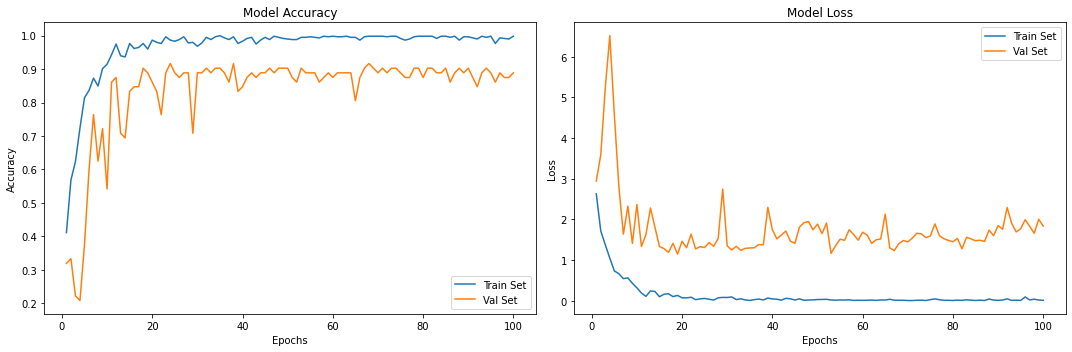

In [ ]:
# Plot model performance
acc = IncepV3_history.history['dense_3_accuracy']
val_acc = IncepV3_history.history['val_dense_3_accuracy']
loss = IncepV3_history.history['loss']
val_loss = IncepV3_history.history['val_loss']
epochs_range = range(1, len(IncepV3_history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [ ]:
Y_pred = IncepV3.predict(test_dataset)

314/314 [==============================] - 8s 17ms/step


In [ ]:
pred_incepV3_0 = np.argmax(Y_pred[0], axis = 1)
pred_incepV3_0

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 3,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       3, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 0, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, pred_incepV3_0)

0.9171974522292994

In [ ]:
pred_incepV3_1 = np.argmax(Y_pred[1], axis = 1)
pred_incepV3_1

array([0, 0, 3, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0,
       1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 1, 3, 0, 3, 3, 3, 0, 3, 3, 3, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, pred_incepV3_1)

0.9076433121019108

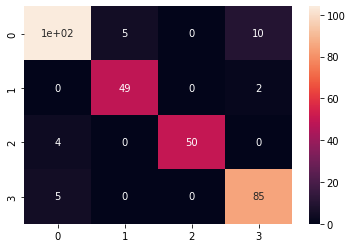

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, pred_incepV3_0)
sns.heatmap(cm, annot=True)

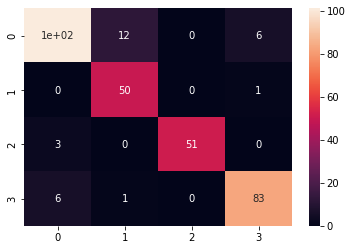

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, pred_incepV3_1)
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, pred_incepV3_0))

              precision    recall  f1-score   support

           0       0.92      0.87      0.90       119
           1       0.91      0.96      0.93        51
           2       1.00      0.93      0.96        54
           3       0.88      0.94      0.91        90

    accuracy                           0.92       314
   macro avg       0.93      0.93      0.93       314
weighted avg       0.92      0.92      0.92       314



In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, pred_incepV3_1))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88       119
           1       0.79      0.98      0.88        51
           2       1.00      0.94      0.97        54
           3       0.92      0.92      0.92        90

    accuracy                           0.91       314
   macro avg       0.91      0.92      0.91       314
weighted avg       0.91      0.91      0.91       314

